In [1]:
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Normalization, GlobalAveragePooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation

In [2]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

class DataLoader:
    def __init__(self, root_path):
        if IN_COLAB:
        	# Mount Google Drive
            drive.mount('/content/drive')
            self.root = '/content/drive/MyDrive/' + root_path
        else:
            self.root = root_path

    def load_image_data(self, path, image_size, batch_size, shuffle):
        data_directory = self.root + path

        dataset = image_dataset_from_directory(
            data_directory,
            image_size=(image_size, image_size),
            batch_size=batch_size,
            shuffle=shuffle
		    )

        return dataset

In [4]:
data_loader = DataLoader('split_data_white_padded')

train_data_path = '/train'
test_data_path = '/test'
validation_data_path = '/validation'

IMAGE_SIZE = 224
BATCH_SIZE = 32
SHUFFLE = True

train_dataset = data_loader.load_image_data(train_data_path, IMAGE_SIZE, BATCH_SIZE, SHUFFLE)
validation_dataset = data_loader.load_image_data(validation_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)
test_dataset = data_loader.load_image_data(test_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4121 files belonging to 2 classes.
Found 1154 files belonging to 2 classes.
Found 577 files belonging to 2 classes.


In [5]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.2))

In [6]:
def preprocess(dataset, augment=False):
  # Resize and rescale all datasets.
  dataset = dataset.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y),
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    dataset = dataset.map(lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
train_dataset = preprocess(train_dataset, augment=True)
validation_dataset = preprocess(validation_dataset)

In [8]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape = (224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(1, activation='sigmoid')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with your loaded data using the data loader
model_history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset)


Epoch 1/25
129/129 [==============================] - 74s 269ms/step - loss: 3.9377 - accuracy: 0.9136 - val_loss: 0.1040 - val_accuracy: 0.9619
Epoch 2/25
129/129 [==============================] - 36s 265ms/step - loss: 0.1362 - accuracy: 0.9481 - val_loss: 0.0813 - val_accuracy: 0.9705
Epoch 3/25
129/129 [==============================] - 36s 263ms/step - loss: 0.1090 - accuracy: 0.9595 - val_loss: 0.0795 - val_accuracy: 0.9688
Epoch 4/25
129/129 [==============================] - 36s 266ms/step - loss: 0.0884 - accuracy: 0.9665 - val_loss: 0.0967 - val_accuracy: 0.9671
Epoch 5/25
129/129 [==============================] - 36s 265ms/step - loss: 0.0650 - accuracy: 0.9728 - val_loss: 0.0726 - val_accuracy: 0.9766
Epoch 6/25
129/129 [==============================] - 36s 267ms/step - loss: 0.0680 - accuracy: 0.9738 - val_loss: 0.0876 - val_accuracy: 0.9705
Epoch 7/25
129/129 [==============================] - 36s 265ms/step - loss: 0.0741 - accuracy: 0.9750 - val_loss: 0.0728 - val_ac

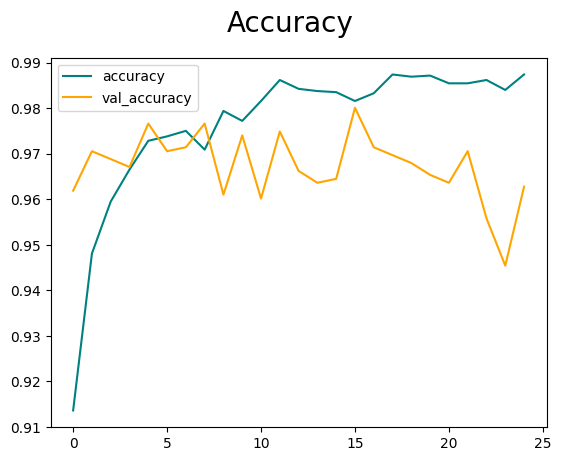

In [9]:
fig = plt.figure()
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

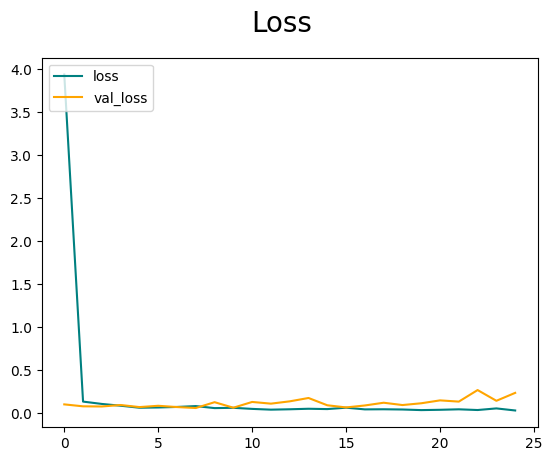

In [10]:
fig = plt.figure()
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
test_dataset_normalized = preprocess(test_dataset)

In [16]:
# Save the trained model for later use
model.save("/content/drive/MyDrive/resnet_glomeruli_classifier", save_format="h5")

19/19 [==============================] - 36s 2s/step - loss: 0.1745 - accuracy: 0.9792
Test accuracy: 0.9792027473449707
19/19 [==============================] - 5s 181ms/step


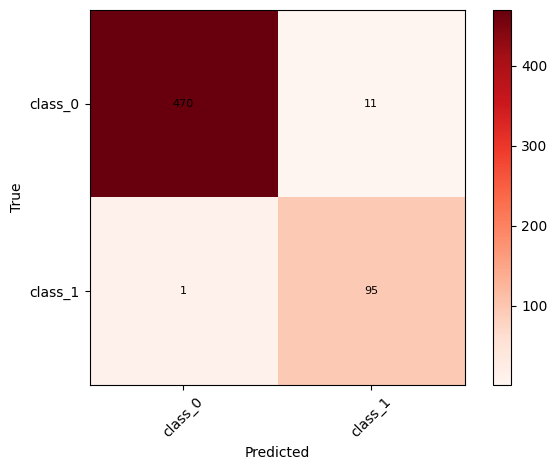

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset_normalized)
print("Test accuracy:", accuracy)

# Generate predictions for confusion matrix
y_pred = model.predict(test_dataset_normalized)
y_pred_classes = tf.where(y_pred > 0.5, 1, 0)
y_true = tf.concat([y for _, y in test_dataset], axis=0)

# Calculate and plot confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
# Annotate each cell with the corresponding value

plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(test_dataset.class_names)), test_dataset.class_names, rotation=45)
plt.yticks(range(len(test_dataset.class_names)), test_dataset.class_names)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        value = cm[i, j].numpy()
        plt.text(i, j, value, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()